<a href="https://colab.research.google.com/github/vfrantc/COVID-CT/blob/master/36_bacteria_cnn_plus_deformable_regular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+git://github.com/vfrantc/matilda.git
!pip install livelossplot

     |████████████████████████████████| 516.2MB 32kB/s 


In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import PredefinedSplit

from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from google.colab import drive

%matplotlib inline
import matilda as mt
from matilda import get_strategy
from matilda.nets.wrn_harm import block
from matilda.nets.wrn_harm import group
import livelossplot


# Prepare data

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!cp -r /content/gdrive/My\ Drive/fusion2 .
!unzip fusion2/img_file_all_16.zip -d fusion2

Streaming output truncated to the last 5000 lines.
  inflating: fusion2/img_file_all_16/Campy/00-005.tif  
  inflating: fusion2/img_file_all_16/Campy/00-006.tif  
  inflating: fusion2/img_file_all_16/Campy/00-007.tif  
  inflating: fusion2/img_file_all_16/Campy/00-008.tif  
  inflating: fusion2/img_file_all_16/Campy/00-009.tif  
  inflating: fusion2/img_file_all_16/Campy/00-010.tif  
  inflating: fusion2/img_file_all_16/Campy/00-011.tif  
  inflating: fusion2/img_file_all_16/Campy/00-012.tif  
  inflating: fusion2/img_file_all_16/Campy/00-013.tif  
  inflating: fusion2/img_file_all_16/Campy/00-014.tif  
  inflating: fusion2/img_file_all_16/Campy/00-015.tif  
  inflating: fusion2/img_file_all_16/Campy/00-016.tif  
  inflating: fusion2/img_file_all_16/Campy/00-017.tif  
  inflating: fusion2/img_file_all_16/Campy/00-018.tif  
  inflating: fusion2/img_file_all_16/Campy/00-019.tif  
  inflating: fusion2/img_file_all_16/Campy/00-020.tif  
  inflating: fusion2/img_file_all_16/Campy/00-021.tif

In [5]:
##load data index
train_index_path=r'fusion2/index_file/train_index.csv'
valide_index_path=r'fusion2/index_file/valide_index.csv'
test_index_path=r'fusion2/index_file/test_index.csv'
train_index=pd.read_csv(train_index_path)['0'].values.astype(np.int)
valide_index=pd.read_csv(valide_index_path)['0'].values.astype(np.int)
test_index=pd.read_csv(test_index_path)['0'].values.astype(np.int)

In [6]:
####load spectral data
spectral_data_path=r'fusion2/All_spectrum_Nor_SNV.csv'
spectral_data=pd.read_csv(spectral_data_path).drop(columns=['No','Class']).values
y_all=pd.read_csv(spectral_data_path)['Class'].values
x_spectral_train=spectral_data[train_index]
x_spectral_valide=spectral_data[valide_index]
x_spectral_test=spectral_data[test_index]
y_train=tf.keras.utils.to_categorical(y_all[train_index])
y_valide=tf.keras.utils.to_categorical(y_all[valide_index])
y_test=tf.keras.utils.to_categorical(y_all[test_index])
from sklearn import preprocessing
spectral_scaler = preprocessing.StandardScaler().fit(x_spectral_train)
x_spectral_train_st=spectral_scaler.fit_transform(x_spectral_train)
x_spectral_valide_st=spectral_scaler.fit_transform(x_spectral_valide)
x_spectral_test_st=spectral_scaler.fit_transform(x_spectral_test)

In [7]:
#####TO GET IMAGE DATA
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    z = []
    for cell_type in os.listdir(folder):
        if not cell_type.startswith('.'):
            if cell_type in ['Ecoli']:
                label = 1
                label2 = 1
            elif cell_type in ['Listeria']:
                label = 2
                label2 = 2
            elif cell_type in ['SA']:
                label = 3
                label2 = 3
            elif cell_type in ['ST']:
                label = 4
                label2 = 4
            elif cell_type in ['Campy']:
                label = 0
                label2 = 0
            for pro_name in tqdm(os.listdir(folder +'/'+ cell_type)):
                img_data = imread(folder + '/'+cell_type + '/' + pro_name)
                if img_data is not None:
                    img_file = d_resize(img_data)
                    X.append(img_file)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)/10000   
    X=X[:,:,:,np.newaxis]
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

def d_resize(image):        ###to resize image
    resized_img=[]
    max_dim =64
    h, w = image.shape[:2]
    top_pad = (max_dim - h) // 2
    bottom_pad = max_dim - h - top_pad
    left_pad = (max_dim - w) // 2
    right_pad = max_dim - w - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad)]
    image_new = np.pad(image, padding, mode='constant', constant_values=0)
    return(image_new)

In [8]:
###To get image
from skimage.external.tifffile import imread
data_path = r'fusion2/img_file_all_16'
x_img_16, y_img_16, z_img_16 = get_data(data_path)
classes=5
x_img_train=x_img_16[train_index]
x_img_valide=x_img_16[valide_index]
x_img_test=x_img_16[test_index]
y_img_train=to_categorical(y_img_16[train_index],classes)
y_img_valide=to_categorical(y_img_16[valide_index],classes)
y_img_test=to_categorical(y_img_16[test_index],classes)

100%|██████████| 1000/1000 [00:00<00:00, 2167.55it/s]


# Train multilayer perceptron

In [9]:
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 60:
        lr *= 0.2
    if epoch > 120:
        lr *= 0.2
    if epoch > 160:
        lr *= 0.2
    return lr

In [10]:
def chebychev_fb(n=7):
  C = np.zeros(shape=(n, n), dtype=np.float32)
  for k in range(n):
    for m in range(n):
      if m == 0:
        pm = 1
      else:
        pm = 2
      C[m, k] = pm*math.pow(-1, m)*math.cos((math.pi*m/n)*(k+0.5)) / n
  return tf.convert_to_tensor(C[:, np.newaxis, :], dtype=tf.float32)

In [11]:
class Harm1D(tf.keras.layers.Layer):
  
  def __init__(self, filters, kernel_size=7):
    super().__init__()
    self._filters = filters
    self.fb = chebychev_fb(n=kernel_size)
  
  def build(self, input_shape):
    self.kernel = self.add_weight("kernel", 
                                  shape=[1, self.fb.shape[0]*input_shape[-1], self._filters], 
                                  initializer='glorot_normal')
    self.built = True

  def call(self, input):
    groups = tf.split(input, axis=-1, num_or_size_splits=input.shape[-1])
    conv_groups = [tf.nn.conv1d(input=group,
                                filters=self.fb,
                                stride=[1,1,1],
                                padding='SAME') for group in groups]
    filtered = tf.concat(conv_groups, axis=-1)
    convolved = tf.nn.conv1d(filtered, filters=self.kernel, stride=[1, 1, 1], padding='SAME')
    return convolved

In [12]:
x_spectral_train_conv  = x_spectral_train_st[..., np.newaxis]
x_spectral_valide_conv = x_spectral_valide_st[..., np.newaxis]
x_spectral_test_conv   = x_spectral_test_st[..., np.newaxis]

In [13]:
def make_model(size, conv_num, dense):
  mlp = tf.keras.models.Sequential()
  mlp.add(tf.keras.layers.Input(shape=(89,1)))
  mlp.add(Harm1D(conv_num, size))
  mlp.add(tf.keras.layers.Activation('relu'))
  mlp.add(tf.keras.layers.Dropout(0.3))
  mlp.add(tf.keras.layers.BatchNormalization())
  mlp.add(tf.keras.layers.MaxPooling1D(pool_size=2))
  mlp.add(tf.keras.layers.Flatten())
  mlp.add(tf.keras.layers.Dense(dense,activation='relu'))
  mlp.add(tf.keras.layers.Dropout(0.3))
  mlp.add(tf.keras.layers.Dense(5,activation='softmax'))
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return mlp

In [14]:
mlp = make_model(size=7, conv_num=64, dense=128)

In [15]:
hist = mlp.fit(x_spectral_train_st, y_train, batch_size=32, epochs=200, validation_data=(x_spectral_valide_st, y_valide), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/200
113/113 [==============================] - 1s 6ms/step - loss: 1.3485 - accuracy: 0.5528 - val_loss: 1.0591 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - 0s 4ms/step - loss: 0.7891 - accuracy: 0.6842 - val_loss: 0.8342 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.7369 - val_loss: 0.6659 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 4/200
113/113 [==============================] - 0s 4ms/step - loss: 0.5650 - accuracy: 0.7775 - val_loss: 0.5777 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 5/200
113/113 [==============================] - 0s 4ms/step - loss: 0.5036 - accuracy: 0.7958 - val_loss: 0.5060 - val_accuracy: 0.8022 - lr: 0.0010
Epoch 6/200
113/113 [==============================] - 0s 4ms/step - loss: 0.4563 - accuracy: 0.8206 - val_loss: 0.4511 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 7/200
113/113 [==============================] - 0s 4ms/st

In [16]:
mlp.evaluate(x_spectral_test_st, y_test)

16/16 [==============================] - 0s 3ms/step - loss: 0.0976 - accuracy: 0.9620


[0.09759852290153503, 0.9620000123977661]

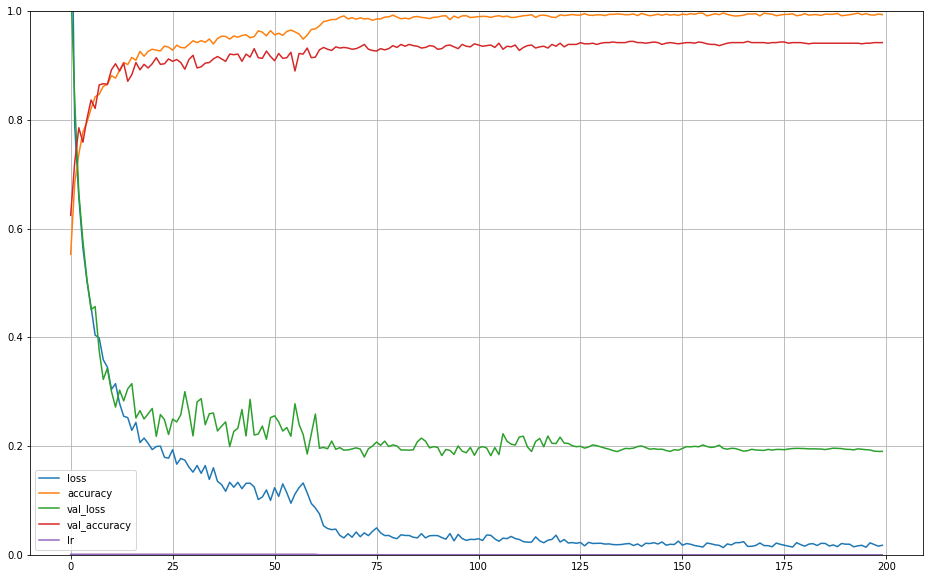

In [17]:
mt.draw_hist(hist)

# CNN

In [57]:
levels = [(0, 0), (1, 0), (0, 1), (1, 1), (2, 2)]

In [58]:
def wrn_harm(input_shape, ftype='chebychev', sz=3, depth=16, width=8, num_classes=10, dropout=0.3):
    assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
    n = (depth - 4) // 6
    widths = [int(v * width) for v in (16, 32, 64)]

    inputs = tf.keras.layers.Input(shape=input_shape, name="image")
    #x = mt.layers.deform.DeformOffset(filters=16, kernel_size=(4,4), padding='same')(inputs)
    x = mt.layers.deform.DeformableConvLayer(filters=16, 
                                             kernel_size=(4, 4), 
                                             activation='relu', 
                                             use_bias=True, 
                                             padding='same',
                                             num_deformable_group=1,
                                             kernel_initializer='glorot_uniform')(inputs)
    # now regular harmonic layer 
    #x = mt.layers.HarmonicTransform(ftype=ftype, n=4, strides=(1, 1, 1, 1))(x)
    #x = mt.layers.AlphaRooting(alpha=0.9, trainable=True, min_value=0.8, max_value=1.2)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = mt.layers.HarmonicCombine(16, activation='relu')(x)

    for width, stride in zip(widths, [1, 2, 2]):
        x = group(x, n, width, stride, dropout=dropout, block_type='lin_harmonic', ftype=ftype, sz=sz, levels=levels)

    x = tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.1,
                                           epsilon=1e-5,
                                           gamma_initializer='uniform')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=16)(x)
    y = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(num_classes,
                                    activation='softmax',
                                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [59]:
im_model = wrn_harm(input_shape=(64, 64, 1), ftype='chebychev', sz=3, depth=16, width=8, num_classes=5, dropout=0.2)

1
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev


In [60]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
im_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
im_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
deformable_conv_layer_6 (Deform (None, 64, 64, 16)   816         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 64, 64, 16)   64          deformable_conv_layer_6[0][0]    
__________________________________________________________________________________________________
activation_79 (Activation)      (None, 64, 64, 16)   0           batch_normalization_82[0][0]     
____________________________________________________________________________________________

In [62]:
history = im_model.fit(x_img_train, y_img_train,
                    epochs=200, 
                    validation_data=(x_img_valide, y_img_valide),
                    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)], verbose=1)

Epoch 1/200
113/113 [==============================] - 40s 356ms/step - loss: 0.9884 - accuracy: 0.6733 - val_loss: 0.6469 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 2/200
113/113 [==============================] - 40s 353ms/step - loss: 0.5170 - accuracy: 0.8628 - val_loss: 0.4159 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 3/200
113/113 [==============================] - 40s 355ms/step - loss: 0.4314 - accuracy: 0.8939 - val_loss: 0.3720 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 4/200
113/113 [==============================] - 40s 354ms/step - loss: 0.3877 - accuracy: 0.9050 - val_loss: 0.3743 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 5/200
113/113 [==============================] - 40s 351ms/step - loss: 0.3445 - accuracy: 0.9167 - val_loss: 0.3693 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 6/200
113/113 [==============================] - 40s 353ms/step - loss: 0.3619 - accuracy: 0.9147 - val_loss: 0.3018 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 7/200
113/113 [=========================

In [66]:
val_acc = max(history.history['val_accuracy'])

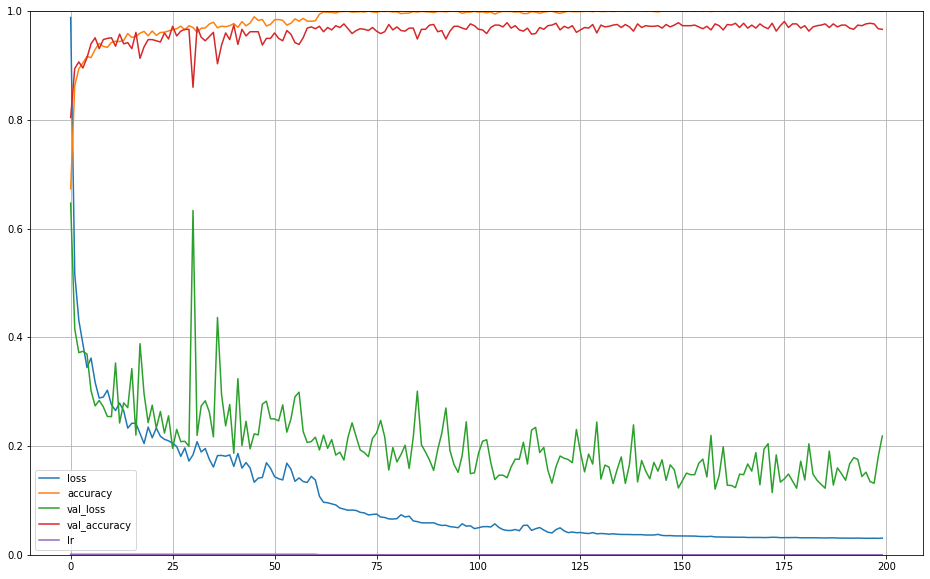

In [67]:
mt.draw_hist(history)

In [68]:
mlp.evaluate(x_spectral_test_st, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 0.0976 - accuracy: 0.9620


[0.09759852290153503, 0.9620000123977661]

# Reinstantiate the models

In [69]:
mlp = make_model(size=7, conv_num=64, dense=128)
im_model = wrn_harm(input_shape=(64, 64, 1), ftype='chebychev', sz=3, depth=16, width=8, num_classes=5, dropout=0.2)

1
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev
chebychev


# Fused model

In [70]:
mlp.trainable = True
im_model.trainable = True

spectral_features_input = mlp.layers[0].input
spectral_features_output = mlp.layers[-2].output

image_features_input = im_model.layers[0].input
image_features_output = im_model.layers[-2].output

feature_merged_layer = tf.keras.layers.concatenate([spectral_features_output, image_features_output])
feature_merged_dense = tf.keras.layers.Dense(1024, activation='relu')(feature_merged_layer)
fusion_output = tf.keras.layers.Dense(5, activation='softmax')(feature_merged_dense)
data_fusion_model = tf.keras.models.Model(inputs=[spectral_features_input, image_features_input], outputs=fusion_output)

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [72]:
data_fusion_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
fusion_model_name = 'final_model.h5'

#checkpointer = tf.keras.callbacks.ModelCheckpoint(fusion_model_name, save_best_only=True)
plot_losses = livelossplot.PlotLossesKerasTF()
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=20, mode='auto')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, verbose=0)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

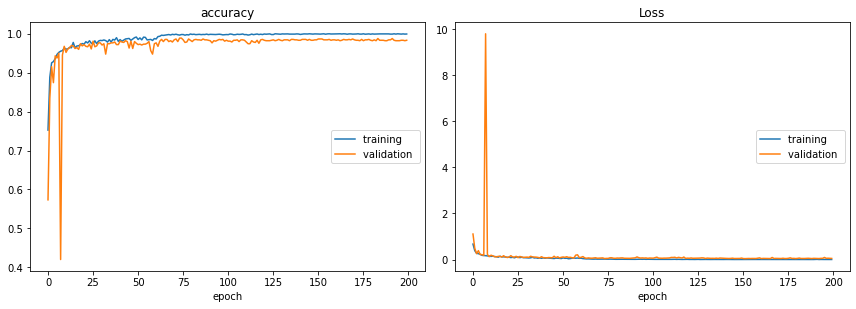

accuracy
	training         	 (min:    0.752, max:    1.000, cur:    0.999)
	validation       	 (min:    0.420, max:    0.989, cur:    0.983)
Loss
	training         	 (min:    0.006, max:    0.674, cur:    0.007)
	validation       	 (min:    0.045, max:    9.788, cur:    0.052)
113/113 [==============================] - 40s 354ms/step - loss: 0.0068 - accuracy: 0.9994 - val_loss: 0.0523 - val_accuracy: 0.9833 - lr: 8.0000e-06


In [74]:
data_fusion_model.fit([x_spectral_train_conv, x_img_train], y_img_train, batch_size=32, epochs=200, validation_data=([x_spectral_valide_conv, x_img_valide], y_img_valide), callbacks=[plot_losses, reduce_lr])

In [75]:
data_fusion_model.evaluate([x_spectral_test_conv, x_img_test], y_img_test)

16/16 [==============================] - 3s 183ms/step - loss: 0.0138 - accuracy: 0.9980


[0.013791639357805252, 0.9980000257492065]

In [76]:
from sklearn.metrics import classification_report

In [77]:
y_pred = data_fusion_model.predict([x_spectral_test_conv, x_img_test])

In [78]:
print(classification_report(np.argmax(y_pred, axis=-1), np.argmax(y_img_test, axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      0.99      1.00       101
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       0.99      1.00      0.99        99

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



# FENCY PLOTS

In [79]:
####code for ROC_AUC 
from sklearn.metrics import roc_curve, auc
from keras.utils import np_utils
from scipy import interp
classes=5
def fpr_tpr_roc_auc(classifier,x,y):
    y_predict=classifier.predict_proba(x)
   # y_predict_onehot=np_utils.to_categorical(y_predict,classes)
    y_onehot=np_utils.to_categorical(y,classes)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i],y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return(fpr,tpr,roc_auc)
def svm_fpr_tpr_roc_auc(classifier,x,y):
    y_predict=classifier.decision_function(x)
    y_onehot=np_utils.to_categorical(y,classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i],y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return(fpr,tpr,roc_auc)

Using TensorFlow backend.


In [80]:
###Code for ROC_plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
font0=matplotlib.font_manager.FontProperties()
font0.set_style('italic')

def roc_plot(fpr,tpr,roc_auc,classifier):
    sns.set(font_scale=2)
    sns.set_style('white')
    lw=4
    colors=['b', 'g', 'r', 'c', 'm']
    plt.figure(figsize=(8,6), dpi=1000)
    sns.lineplot(x=fpr["macro"], y=tpr["macro"],lw=lw)
    plt.plot(fpr[0], tpr[0], lw=lw)
    for i, color in zip(range(classes-1), colors):
        sns.lineplot(x=fpr[i+1], y=tpr[i+1], lw=lw)
    plt.legend(['Average (area = {1:0.2f})'''.format(0, roc_auc["macro"]),'C. jejuni (area = {1:0.2f})'''.format(1, roc_auc[0]),'E. coli (area = {1:0.2f})'''.format(2, roc_auc[1]),'L. innocua (area = {1:0.2f})'''.format(3, roc_auc[2]),'S. aureus (area = {1:0.2f})'''.format(4, roc_auc[3]),'S. Typhimurium (area = {1:0.2f})'''.format(5, roc_auc[4])],prop=font0,labelspacing=0.4,fontsize=54,title='Species')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc Curve of '+classifier)
    sns.despine()
    return()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [81]:
#Code for confusion_matrix plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
def make_confusion_matrix(classifier,x,y):
    y_pred=classifier.predict(x)
    cm=confusion_matrix(y,y_pred)
    return(cm)
def print_confusion_matrix(confusion_matrix, class_names,classifier,figsize = (8,6)):
    font0=matplotlib.font_manager.FontProperties()
    font0.set_style('italic')
    sns.set(font_scale=2)
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize, dpi=1000)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontproperties=font0)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontproperties=font0)
    plt.ylabel('True species')
    plt.xlabel('Predicted species')
    plt.title('Confusion matrix of '+classifier)
    return fig


In [ ]:
####Code for Neural Net ROC_AUC plot (1DCNN,LSTM,ResNet& FusionNet )
from sklearn.metrics import roc_curve, auc
from keras.utils import np_utils
from scipy import interp
classes=5
def nn_fpr_tpr_roc_auc(classifier,x,y):
    y_predict=classifier.predict(x)
    y_onehot=y
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i],y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return(fpr,tpr,roc_auc)


In [ ]:
####Code for Neural Net Confusion_Matrics (1DCNN,LSTM,ResNet& FusionNet )
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
def nn_make_confusion_matrix(classifier,x,y):
    y_pred=classifier.predict(x)
    cm=confusion_matrix(y.argmax(1),y_pred.argmax(1))
    return(cm)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


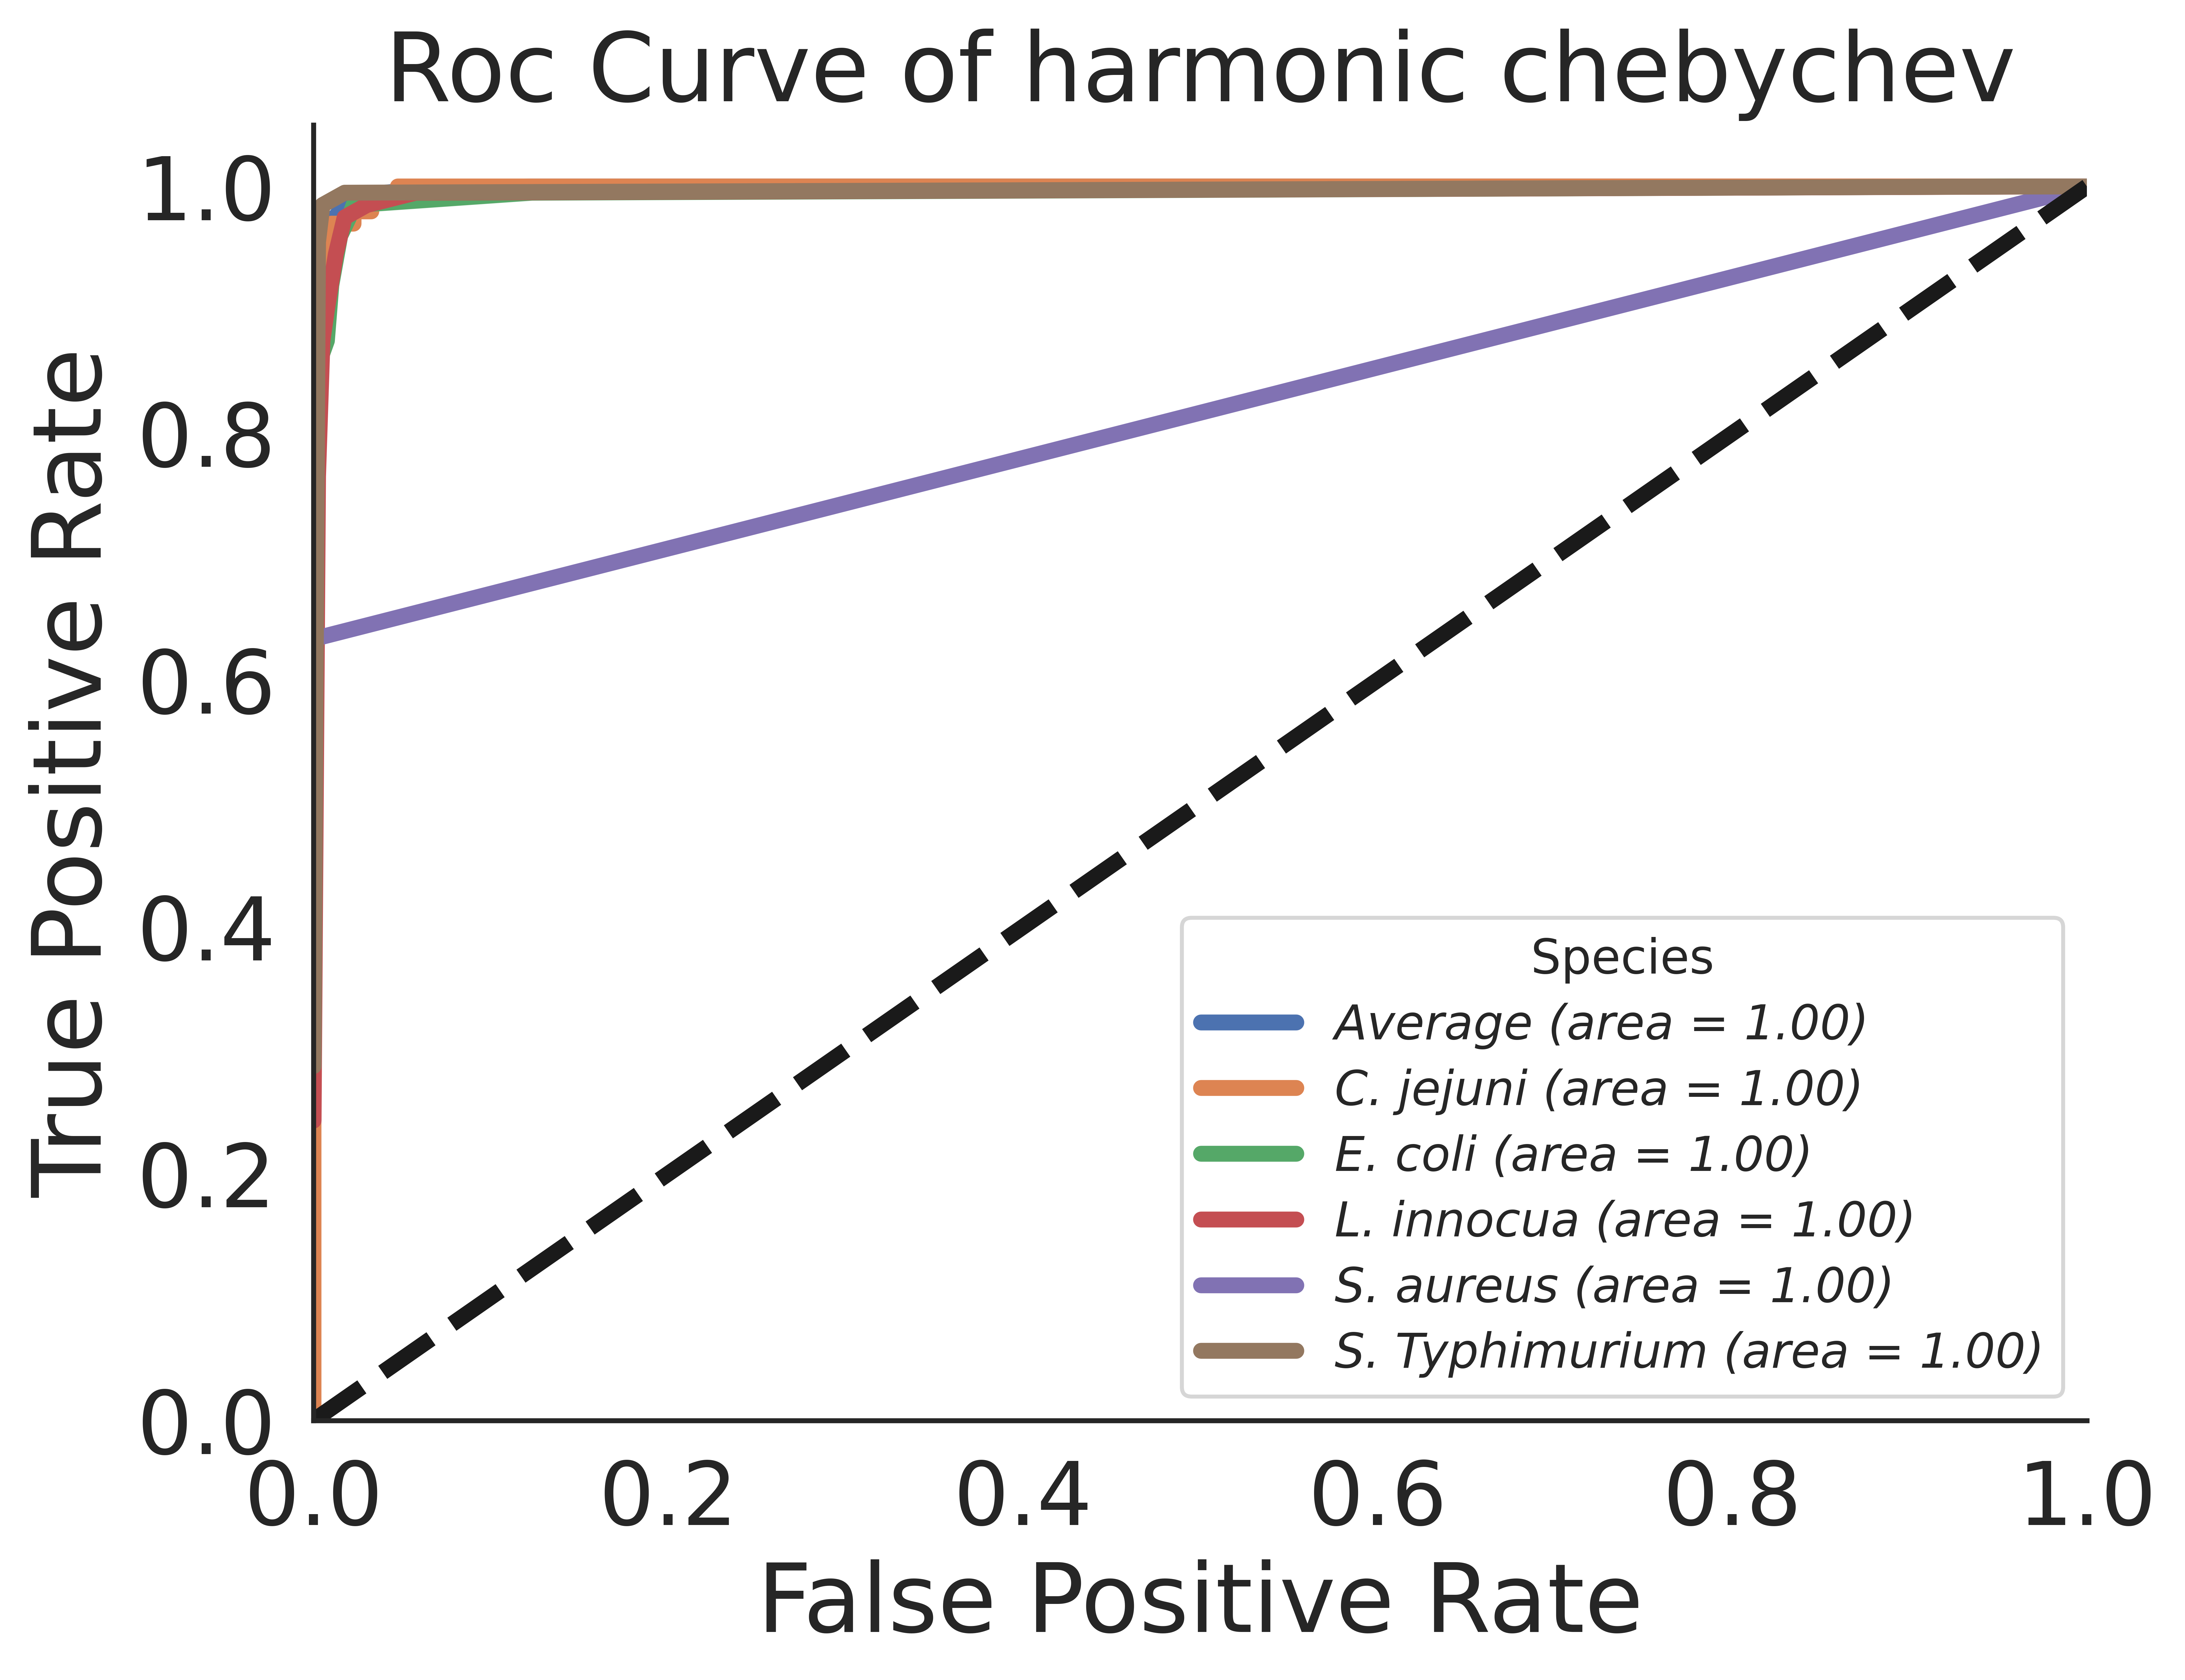

In [ ]:
####Plot FusionNet ROC_AUC
fusion_fpr,fusion_tpr,fusion_roc_auc=nn_fpr_tpr_roc_auc(data_fusion_model,[x_spectral_test_conv,x_img_test],y_img_test)
p=roc_plot(fusion_fpr,fusion_tpr,fusion_roc_auc,'harmonic chebychev')


In [ ]:
####Plot FusioNET Confusion matrics
class_names=['C. jejuni','E. coli','L. innocua','S. aureus','S. Typhimurium']
cnn_plot=print_confusion_matrix(nn_make_confusion_matrix(data_fusion_model,[x_spectral_test_conv, x_img_test],y_img_test),class_names,'harmonic chebychev')

# Just feature extraction

In [ ]:
spectral_features_input = mlp.layers[0].input
spectral_features_output = mlp.layers[-2].output

image_features_input = im_model.layers[0].input
image_features_output = im_model.layers[-2].output

feature_merged_layer = tf.keras.layers.concatenate([spectral_features_output, image_features_output])
feature_extractor_model = tf.keras.models.Model(inputs=[spectral_features_input, image_features_input], outputs=feature_merged_layer)

In [ ]:
x_train = feature_extractor_model.predict([x_spectral_train_st, x_img_train])
x_valide = feature_extractor_model.predict([x_spectral_valide_st, x_img_valide])
x_test = feature_extractor_model.predict([x_spectral_test_st, x_img_test])

In [ ]:
y_train = np.argmax(y_img_train, axis=1)
y_valide = np.argmax(y_img_valide, axis=1)
y_test = np.argmax(y_img_test, axis=1)

In [ ]:
print(x_train.shape, x_valide.shape, x_test.shape)

In [ ]:
x_train = np.concatenate([x_train, x_valide], axis=0)

In [ ]:
print(x_train.shape)

In [ ]:
y_train = np.concatenate([y_train, y_valide], axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
np.unique(y_train)

In [ ]:
def spot_check_algorithms(X_train, Y_train):
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=42)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return results, names

In [ ]:
results, names = spot_check_algorithms(X_train=x_train, Y_train=y_train)

In [ ]:
SVC?

In [ ]:
x_train.shape

(4500, 640)

In [ ]:
model = SVC(kernel='poly', C=0.015, gamma='auto')
kfold = KFold(n_splits=10, random_state=42)
cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
print(np.mean(cv_results))

0.579111111111111
